In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, ImageCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import exifread
from dataclasses import dataclass
from datetime import datetime
from random import randint
import cv2

# Configurar la visualización de gráficos en el notebook
%matplotlib inline

In [5]:
@dataclass
class Thermogram:
    path: str

    @property
    def raw(self) -> np.ndarray:
        return imread(self.path)

    @property
    def kelvin(self) -> np.ndarray:
        return self.raw * 0.04
    
    @property
    def celsius(self) -> np.ndarray:
        return self.kelvin - 273.15

    @property
    def fahrenheit(self) -> np.ndarray:
        return (self.celsius * 1.8) + 32.0        
    
    def render(self) -> np.ndarray:
        image = self.celsius
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        return (image * 255.0).astype(np.uint8)

Number of images found: 1075


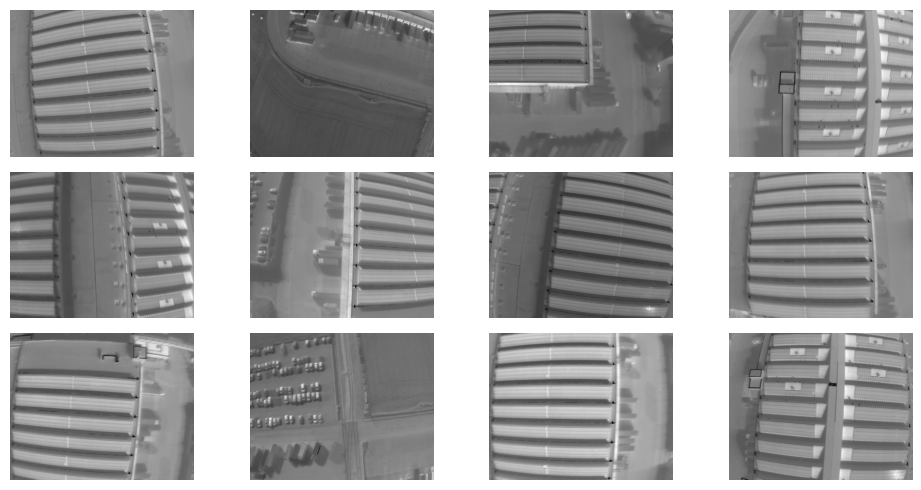

In [6]:
IMAGES_PATH = '/Users/juangamez/Documents/GitHub/taller-solar/images'

images = ImageCollection(
    load_pattern=IMAGES_PATH + '/*.tif', 
    load_func=lambda x: Thermogram(x)
)

print(f'Number of images found: {len(images)}')

plt.figure(figsize=(10,5))
for id in range(1, 13):
    thermogram = images[randint(0, len(images.files) - 1)]
    plt.subplot(3, 4, id)
    plt.imshow(thermogram.raw, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

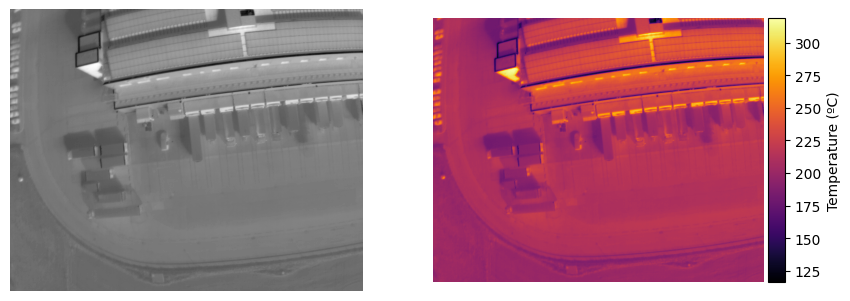

In [7]:
# Elegir una imagen aleatoria
thermogram = images[randint(0, len(images.files) - 1)]

# Mostrar la imagen térmica
_, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(thermogram.raw, cmap='gray')
ax[0].set_axis_off()
im = ax[1].imshow(thermogram.celsius, cmap='inferno')
ax[1].set_axis_off()
cax = make_axes_locatable(ax[1]).append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, values=np.unique(thermogram.celsius), label='Temperature (ºC)')
plt.show()

In [8]:
class MetadataExtractor:
    def __init__(self, path):
        self.path = path
        self.metadata = {}

    def extract(self):
        with open(self.path, 'rb') as file:
            tags = exifread.process_file(file)
            for tag in tags.keys():
                self.metadata[tag] = tags[tag]

        # Procesar y corregir los metadatos relevantes
        self.__correct_metadata()

    def __correct_metadata(self):
        def convert_to_degrees(value):
            d, m, s = [float(x.num)/float(x.den) for x in value.values]
            return d + (m/60.0) + (s/3600.0)

        gps_latitude = self.metadata.get('GPS GPSLatitude')
        gps_latitude_ref = self.metadata.get('GPS GPSLatitudeRef')
        gps_longitude = self.metadata.get('GPS GPSLongitude')
        gps_longitude_ref = self.metadata.get('GPS GPSLongitudeRef')

        if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
            self.metadata['GPSLatitude'] = convert_to_degrees(gps_latitude)
            if gps_latitude_ref.values[0] != 'N':
                self.metadata['GPSLatitude'] = -self.metadata['GPSLatitude']

            self.metadata['GPSLongitude'] = convert_to_degrees(gps_longitude)
            if gps_longitude_ref.values[0] != 'E':
                self.metadata['GPSLongitude'] = -self.metadata['GPSLongitude']

def load_metadata(path):
    extractor = MetadataExtractor(path)
    extractor.extract()
    return extractor.metadata

metadata = ImageCollection(
    load_pattern=IMAGES_PATH + '/*.tif', 
    load_func=load_metadata
)
metadata = pd.DataFrame(list(metadata))

# Drop non-essential columns for simplicity, only if they exist
columns_to_drop = [
    'BitsPerSample', 'Compression', 'StripOffsets', 'SamplesPerPixel', 
    'StripByteCounts', 'ApplicationNotes', 'ExifOffset', 'GPSInfo'
]
metadata = metadata.drop(columns=[col for col in columns_to_drop if col in metadata.columns], axis=1)

# Verificar las columnas disponibles
print("Columnas disponibles en el DataFrame:")
print(metadata.columns)

# Ajustar el análisis temporal basado en la columna disponible
if 'EXIF DateTimeOriginal' in metadata.columns:
    # Convertir las fechas a datetime
    metadata['EXIF DateTimeOriginal'] = pd.to_datetime(metadata['EXIF DateTimeOriginal'], format='%Y:%m:%d %H:%M:%S')
    inspection_time = metadata['EXIF DateTimeOriginal'].sort_values()
    inspection_diffs = inspection_time.diff().dropna().dt.total_seconds()
    print('Tiempos de inspección (segundos):', inspection_diffs.describe())
else:
    print("La columna 'EXIF DateTimeOriginal' no está disponible en los metadatos.")

# Análisis simple de metadatos
print(metadata.head())

Columnas disponibles en el DataFrame:
Index(['Image Tag 0x000B', 'Image ImageWidth', 'Image ImageLength',
       'Image BitsPerSample', 'Image Compression', 'Image Make', 'Image Model',
       'Image StripOffsets', 'Image SamplesPerPixel', 'Image StripByteCounts',
       'Image ApplicationNotes', 'Image ExifOffset', 'GPS GPSLatitudeRef',
       'GPS GPSLatitude', 'GPS GPSLongitudeRef', 'GPS GPSLongitude',
       'GPS GPSAltitude', 'Image GPSInfo', 'EXIF DateTimeOriginal',
       'GPSLatitude', 'GPSLongitude'],
      dtype='object')
Tiempos de inspección (segundos): count    1074.000000
mean        0.226257
std         1.378175
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        30.000000
Name: EXIF DateTimeOriginal, dtype: float64
  Image Tag 0x000B Image ImageWidth Image ImageLength Image BitsPerSample  \
0             eBee              640               512                  16   
1             eBee              640               512         

In [9]:
# Imprimir todas las columnas del DataFrame para verificar su contenido
print(metadata.columns)

Index(['Image Tag 0x000B', 'Image ImageWidth', 'Image ImageLength',
       'Image BitsPerSample', 'Image Compression', 'Image Make', 'Image Model',
       'Image StripOffsets', 'Image SamplesPerPixel', 'Image StripByteCounts',
       'Image ApplicationNotes', 'Image ExifOffset', 'GPS GPSLatitudeRef',
       'GPS GPSLatitude', 'GPS GPSLongitudeRef', 'GPS GPSLongitude',
       'GPS GPSAltitude', 'Image GPSInfo', 'EXIF DateTimeOriginal',
       'GPSLatitude', 'GPSLongitude'],
      dtype='object')


In [10]:
metadata 

,Image Tag 0x000B,Image ImageWidth,Image ImageLength,Image BitsPerSample,Image Compression,Image Make,Image Model,Image StripOffsets,Image SamplesPerPixel,Image StripByteCounts,...,Image ExifOffset,GPS GPSLatitudeRef,GPS GPSLatitude,GPS GPSLongitudeRef,GPS GPSLongitude,GPS GPSAltitude,Image GPSInfo,EXIF DateTimeOriginal,GPSLatitude,GPSLongitude
0,eBee,640,512,16,Uncompressed,senseFly,senseFlyThermal,3638,1,655360,...,3478,N,"[116338487/2500000, 0, 0]",E,"[65555501/10000000, 0, 0]",16503109/31250,3516,2014-10-23 10:33:49,46.535395,6.555550
1,eBee,640,512,16,Uncompressed,senseFly,senseFlyThermal,3636,1,655360,...,3476,N,"[232677029/5000000, 0, 0]",E,"[65555559/10000000, 0, 0]",8251423/15625,3514,2014-10-23 10:33:49,46.535406,6.555556
2,eBee,640,512,16,Uncompressed,senseFly,senseFlyThermal,3634,1,655360,...,3474,N,"[232677077/5000000, 0, 0]",E,"[65555613/10000000, 0, 0]",8251047/15625,3512,2014-10-23 10:33:49,46.535415,6.555561
3,eBee,640,512,16,Uncompressed,senseFly,senseFlyThermal,3638,1,655360,...,3478,N,"[465354257/10000000, 0, 0]",E,"[65555673/10000000, 0, 0]",16505503/31250,3516,2014-10-23 10:33:49,46.535426,6.555567
4,eBee,640,512,16,Uncompressed,senseFly,senseFlyThermal,3638,1,655360,...,3478,N,"[465354359/10000000, 0, 0]",E,"[65555733/10000000, 0, 0]",16510103/31250,3516,2014-10-23 10:33:49,46.535436,6.555573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,eBee,640,512,16,Uncompressed,senseFly,senseFlyThermal,3638,1,655360,...,3478,N,"[58171757/1250000, 0, 0]",E,"[65569547/10000000, 0, 0]",1647039/3125,3516,2014-10-23 10:37:52,46.537406,6.556955
1071,eBee,640,512,16,Uncompressed,senseFly,senseFlyThermal,3638,1,655360,...,3478,N,"[465374157/10000000, 0, 0]",E,"[13113917/2000000, 0, 0]",1647094/3125,3516,2014-10-23 10:37:52,46.537416,6.556959
1072,eBee,640,512,16,Uncompressed,senseFly,senseFlyThermal,3640,1,655360,...,3480,N,"[232687129/5000000, 0, 0]",E,"[524557/80000, 0, 0]",16472433/31250,3518,2014-10-23 10:37:52,46.537426,6.556963
1073,eBee,640,512,16,Uncompressed,senseFly,senseFlyThermal,3640,1,655360,...,3480,N,"[465374359/10000000, 0, 0]",E,"[13113933/2000000, 0, 0]",3294807/6250,3518,2014-10-23 10:37:52,46.537436,6.556966


In [11]:
# Seleccionar la primera fila del DataFrame
row = metadata.iloc[0]

# Calcular el tiempo de inspección utilizando la columna 'EXIF DateTimeOriginal'
inspection_time_series = metadata['EXIF DateTimeOriginal'].sort_values()

# Asegurarse de que tenemos al menos dos timestamps para calcular la diferencia
if len(inspection_time_series) > 1:
    inspection_time = (inspection_time_series.iloc[-1] - inspection_time_series.iloc[0]).total_seconds()
else:
    inspection_time = 0

# Imprimir el reporte de inspección
print('='*10, 'Inspection Report', '='*10)
print(f"""
Company name: {row['Image Make']}
Camera model: {row['Image Model']}
Drone name: eBee  # Supongo que 'drone' se refiere a 'Image Tag 0x000B' en nuestro caso
Inspection time: {int(inspection_time // 60)} minutes and {int(inspection_time % 60)} seconds
Images width: {row['Image ImageWidth']}
Images length: {row['Image ImageLength']}
""")

========== Inspection Report ==========

Company name: senseFly
Camera model: senseFlyThermal
Drone name: eBee  # Supongo que 'drone' se refiere a 'Image Tag 0x000B' en nuestro caso
Inspection time: 4 minutes and 3 seconds
Images width: 640
Images length: 512



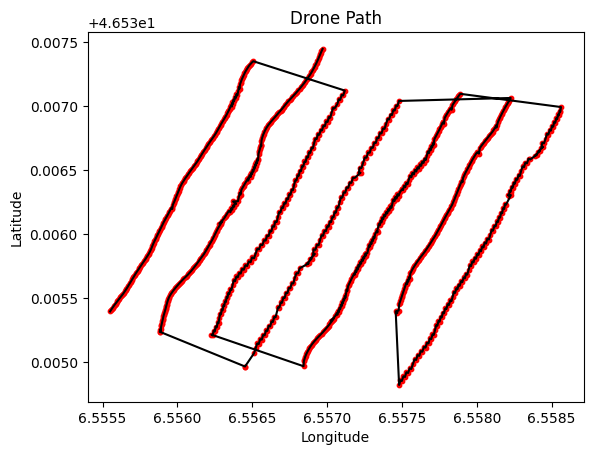

In [12]:
import matplotlib.pyplot as plt

# Asegurarse de que las columnas de latitud y longitud existen en el DataFrame
if 'GPSLongitude' in metadata.columns and 'GPSLatitude' in metadata.columns:
    _, ax = plt.subplots()
    metadata.plot.line(x='GPSLongitude', y='GPSLatitude', ax=ax, color='black', legend=None)
    metadata.plot.scatter(x='GPSLongitude', y='GPSLatitude', ax=ax, color='red', s=10)  # Usar 'red' para mejor visibilidad
    plt.title('Drone Path')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print("Las columnas 'GPSLongitude' y 'GPSLatitude' no están disponibles en los metadatos.")

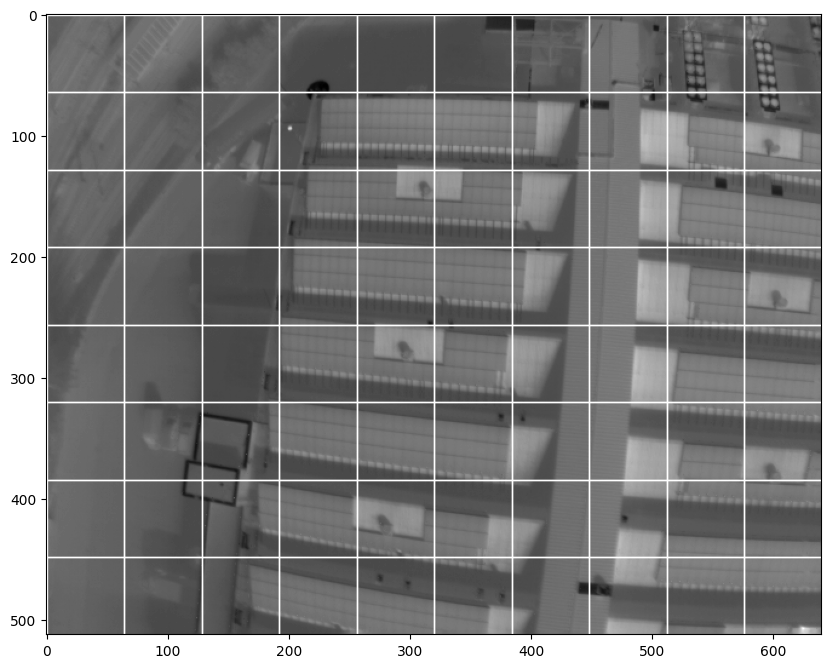

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import ImageCollection
from matplotlib.patches import Rectangle
import json
import os

# Ruta de las imágenes térmicas
IMAGES_PATH = '/Users/juangamez/Documents/GitHub/taller-solar/images'
# Directorio para guardar los archivos JSON
LABELS_PATH = '/Users/juangamez/Documents/GitHub/taller-solar/labels'

# Asegurarse de que el directorio de etiquetas exista
os.makedirs(LABELS_PATH, exist_ok=True)

# Cargar las imágenes
images = ImageCollection(IMAGES_PATH + '/*.tif')

# Parámetros para la cuadrícula
patch_size = 64
stride = 64

# Variables globales para manejar la selección
hotspots = []

def save_hotspots_to_json(hotspots, image_idx):
    filename = os.path.join(LABELS_PATH, f'hotspots_{image_idx}.json')
    with open(filename, 'w') as f:
        json.dump(hotspots, f)

def show_image_with_grid(image, image_idx):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, cmap='gray')
    height, width = image.shape

    # Dibujar la cuadrícula
    for y in range(0, height, stride):
        for x in range(0, width, stride):
            rect = Rectangle((x, y), patch_size, patch_size, linewidth=1, edgecolor='white', facecolor='none')
            ax.add_patch(rect)

    def onclick(event):
        if event.inaxes is not None:
            x = int(event.xdata)
            y = int(event.ydata)
            col = x // stride
            row = y // stride
            x_start = col * stride
            y_start = row * stride

            # Dibujar un rectángulo rojo donde se detecta el click
            rect = Rectangle((x_start, y_start), patch_size, patch_size, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            plt.draw()

            # Guardar la selección de hotspot
            hotspots.append({
                'image_idx': image_idx,
                'x': x_start,
                'y': y_start,
                'width': patch_size,
                'height': patch_size
            })

            # Guardar los hotspots en un archivo JSON y cerrar el plot
            save_hotspots_to_json(hotspots, image_idx)
            plt.close(fig)
            print(f"Hotspot guardado en {LABELS_PATH}/hotspots_{image_idx}.json")

    fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()

# Mostrar una imagen aleatoria con la cuadrícula y permitir la selección de hotspots
def display_image():
    image_idx = np.random.randint(0, len(images.files))
    thermal_image = cv2.normalize(images[image_idx], None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    show_image_with_grid(thermal_image, image_idx)

# Ejecutar la función para mostrar la imagen
display_image()